# Installing Necessary Libraries

In [104]:
pip install convokit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#run this if convokit is unable to install 
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

This is the Corpus Dataset provided by Cornell University. It consists of conversations between various characters in 617 movies and other information like meta data including genre, IMDb rating, etc.

In [105]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

# Q1. Dataset (Data Cleaning) 

The utterances dataset is quite huge and may result in session crashes. Hence, initially, we only sample 20000 rows. We also rename some columns for convenience.

In [106]:
#Getting the dataframes
utterances = corpus.get_utterances_dataframe()
utterances = utterances.sample(n=20000, random_state=42) #Sample random 20000 rows in utterances
conversations = corpus.get_conversations_dataframe()
conversations.rename(columns={'meta.movie_idx': 'meta.movie_id'}, inplace=True) #rename columns for convenience
speakers = corpus.get_speakers_dataframe()
speakers.rename(columns={'meta.movie_idx': 'meta.movie_id'}, inplace=True)

In this assignment, we are trying to predict movie genres using the dialogues of the movies. Before deciding on the desired labels, we will take a look at the top label counts.

In [107]:
top_genres = conversations['meta.genre'].value_counts().head(25)

In [108]:
top_genres

['drama']                                        5027
['comedy', 'romance']                            2950
['comedy', 'drama', 'romance']                   2840
['comedy', 'drama']                              2497
['crime', 'drama', 'thriller']                   2236
['drama', 'romance']                             2125
['comedy']                                       1660
['action', 'crime', 'drama', 'thriller']         1542
['action', 'adventure', 'sci-fi', 'thriller']    1421
['horror', 'mystery', 'thriller']                1330
['thriller']                                     1298
['crime', 'drama', 'mystery', 'thriller']        1279
['crime', 'drama']                               1215
['action', 'adventure', 'thriller']               895
['biography', 'drama']                            854
['crime', 'mystery', 'thriller']                  842
['drama', 'thriller']                             837
['drama', 'mystery', 'thriller']                  834
['horror']                  

This gives us a good idea on what kind of genres we can use. Since, a lot of movies have multiple genres and the Cornell website does not provide information about the weightage of each genre in the movie, it can be non-productive to use labels with multiple genres. Hence, we pick those movies that have only one genre.

In [109]:
single_genres = conversations['meta.genre'].str.count(',') == 0 
single_genre_movies = conversations.loc[single_genres].copy()
unique_genres = single_genre_movies['meta.genre'].unique()
genre_counts = single_genre_movies['meta.genre'].value_counts()
print(genre_counts)

['drama']          5027
['comedy']         1660
['thriller']       1298
['horror']          801
['documentary']     318
[]                  111
['sci-fi']          100
['action']           75
['short']            66
['fantasy']          35
Name: meta.genre, dtype: int64


Note that there are 111 movies that are not labelled. We only choose the top 5 labels and an additional label called romcom. The reason for this is that the other single labelled movies do not have many movies under them and may lead to biased results.

The genres in the conversation dataframe consist of a number of genres in a single list but it looks like a combination of lists due to the usage of braces and commas but they are actually just strings. Hence, the labels are brought to a desired format. Additionally, the rows that have only two genres, comedy and romance are combined to a single genre called romcom. A lot of columns are dropped since merging such huge dataframes leads to session crashes.  

In [110]:
#Getting the desired labels in the right format
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "drama" if x == "['drama']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "horror" if x == "['horror']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "thriller" if x == "['thriller']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "comedy" if x == "['comedy']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "documentary" if x == "['documentary']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "romcom" if x == "['comedy', 'romance']" else x)

In [111]:
#Drop unncessary rows and columns that we will not use for our task 
conversations = conversations.loc[conversations['meta.genre'].isin(['drama', 'horror', 'thriller', 'comedy', 'documentary','romcom'])]
conversations = conversations.drop(columns=['meta.release_year', 'meta.rating', 'meta.votes'], axis=1)
speakers = speakers.drop(columns=['meta.credit_pos', 'meta.gender', 'meta.character_name'], axis=1)

In [112]:
#Merging the three dataframes
import pandas as pd
merged_df = conversations.merge(speakers, on='meta.movie_id').merge(utterances, on='meta.movie_id')
from functools import reduce
dfs = [conversations, utterances, speakers]
final_df = dfs[0]
for df in dfs[1:]:
    final_df = pd.merge(final_df, df, on=['meta.movie_id'], how='inner')

In [113]:
#Sampling 10000 rows
final_df = final_df.sample(n=10000, random_state=42)

For a balanced split of genres in each set, we use stratified sampling to split the dataset into training, testing, and validation split in the ratio of 60:20:20.

In [114]:
#Splitting the dataframe into Train, Test and Validation set using Stratified Sampling
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
y = final_df['meta.genre']

#Split the data into training and the rest with 60:40 split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0) 
for train_index, test_val_index in stratified_split.split(final_df, y):
    train = final_df.iloc[train_index]
    test_val = final_df.iloc[test_val_index]

#Split the remaining 40% data into testing and validation 50:50 split
y_test_val = y.iloc[test_val_index]
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for test_index,val_index in stratified_split.split(test_val, y_test_val):
    test = test_val.iloc[test_index]
    val = test_val.iloc[val_index]

Now, we will analyse the frequencies in all three splits and also plot the corresponding bar graphs.

In [115]:
print("Frequency in stratified_train:")
print(train['meta.genre'].value_counts())

print("\nFrequency in stratified_test:")
print(test['meta.genre'].value_counts())

print("\nFrequency in stratified_validation:")
print(val['meta.genre'].value_counts())

Frequency in stratified_train:
drama          2731
romcom         1618
comedy          873
thriller        507
horror          192
documentary      79
Name: meta.genre, dtype: int64

Frequency in stratified_test:
drama          911
romcom         540
comedy         290
thriller       169
horror          64
documentary     26
Name: meta.genre, dtype: int64

Frequency in stratified_validation:
drama          910
romcom         539
comedy         291
thriller       169
horror          64
documentary     27
Name: meta.genre, dtype: int64


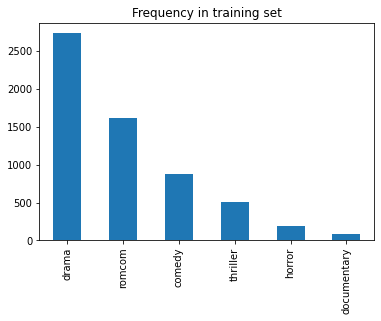

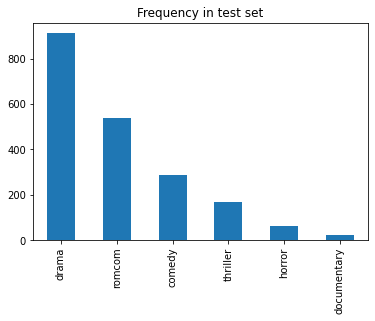

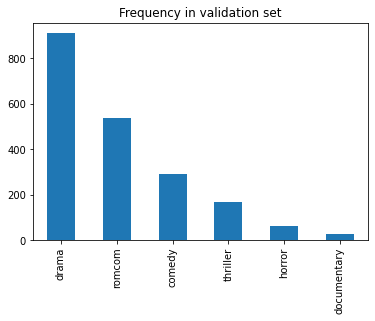

In [116]:
import matplotlib.pyplot as plt
train['meta.genre'].value_counts().plot(kind='bar', title="Frequency in training set")
plt.show()
test['meta.genre'].value_counts().plot(kind='bar', title="Frequency in test set")
plt.show()
val['meta.genre'].value_counts().plot(kind='bar', title="Frequency in validation set")
plt.show()

It is evident from the bar graphs that the label distribution is even across the splits but not inside the splits. In all cases, drama genre has the most number of rows and documentary genre has the least number of rows. This is due to the uneven distribution in the original dataframe. 

# Q2. Clustering

To pre-process the data, tokenization, stemming, and stopword removal is performed.

In [117]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [121]:
import string
def tokenize_rulebased(text):
  prev_c = ''
  tokens = []

  for c in text:
    # Ignore characters that are whitespace (e.g. spaces, tabs, etc)
    if not c in string.whitespace and not c in string.punctuation:
      if prev_c in string.whitespace:
        is_new_token = True
      elif prev_c in string.ascii_letters and c not in string.ascii_letters:
        is_new_token = True
      elif prev_c in string.punctuation and c in string.ascii_letters:
        is_new_token = True
      elif prev_c in string.digits and c in string.punctuation:
        is_new_token = True
      elif prev_c in string.punctuation and c in string.digits:
        is_new_token = True
      else:
        is_new_token = False
      if is_new_token:
        tokens.append(c)
      else: 
        tokens[-1] += c
    prev_c = c # Track what the previous character is

  return tokens  

    

In [122]:
def stemming(tokens): 
  stemmed_tokens = []
  for token in tokens: 
    if token.endswith('ing'):
      token = token[0:-3]
    if token.endswith('ed'):
      token = token[0:-2]
    if token.endswith('s') and tokens != "is":
      token = token[0:-1]
    if token.endswith('izer'):
      token = token[0:-1]
    if token.endswith('able'):
      token = token[0:-4]
    stemmed_tokens.append(token)
  return stemmed_tokens

In [123]:
import nltk
from nltk.corpus import stopwords #remove stopwords using NLTK library

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Additional functions are made to make vocabulary, find the document frequency and make a sparse TF-IDF vector.

In [124]:
def make_vocabulary(corpus): #make vocabulary
  dict = {}
  count = 0
  for i in corpus:
    for j in i:
      if j not in dict:
        dict[j] = count
        count = count+1    
  return dict

In [125]:
def doc_frequency(corpus): #calculate document frequency for all tokens
  unique_tokens = []
  freq = Counter()
  for document in corpus:
    if document not in unique_tokens:
      unique_tokens.append(document)
      for token in document:
        freq[token] = freq[token]+1
  return freq



In [127]:
import math
from collections import Counter

def make_tfidf_sparse(tokens, vocab, doc_freq, N): #Create a sparse vector representation
  sparse = {}
  count = Counter(tokens)
  for token, frequency in count.items():
    if token not in vocab:
      continue
    i = vocab[token]
    if frequency == 0:
      term_freq = 0
    else:
      term_freq = 1 + math.log10(frequency)
    idf = math.log10(N/doc_freq[token])
    sparse[i] = term_freq * idf
  return sparse

Since, a lot of processing has to be done on the dataframes, we will create additional copies of dataframe to carry out the tasks.  We will apply all these functions to the cluster_train dataframe.

In [128]:
cluster_train = train.copy()

In [129]:
cluster_train['tokens'] = cluster_train['text'].apply(tokenize_rulebased) 
cluster_train['tokens'] = cluster_train['tokens'].apply(stemming) 
cluster_train['tokens'] = cluster_train['tokens'].apply(remove_stopwords)

In [130]:
train_vocab = make_vocabulary(cluster_train['tokens'])
train_docfreq = doc_frequency(cluster_train['tokens'])
N = len(cluster_train['tokens'])
train_tfidf_vectors = [ make_tfidf_sparse(pt, train_vocab, train_docfreq, N) for pt in cluster_train['tokens'] ]

The make_tfidf_sparse function that generates a sparse representation of the document where the keys are tokens and values are TF-IDF weights which are the **Vectors**. This function is applied to each document in the cluster_train dataframe. This is called **Vectorization (Step 0)**. 

# K-Means

Now, we will apply K-means. We first select K random centroids. Then, every vector calculated earlier is assigned to its closest vector. The centroids are again selected based on the closest vector. The process repeats until the model converges.

In [131]:
import numpy as np

def sparse_dot_prod(sv1, sv2):
    dot_product = 0
    common_indices = set(sv1.keys()) & set(sv2.keys())
    for index in common_indices:
        dot_product += sv1[index] * sv2[index]
    return dot_product

def sparse_cosine_similarity(sv1, sv2):
  squares = []
  for index,val in sv1.items():
    squares.append(val * val)
  d1 = math.sqrt(sum(squares))
  squares2 = []
  for index,val in sv2.items():
    squares2.append(val * val)
  d2 = math.sqrt(sum(squares))
  if d1 == 0 or d2 == 0:
    return 0
  else:
    sim = sparse_dot_prod(sv1, sv2) / (d1 * d2)
    return sim



In [ ]:
def get_cluster_ids(data_points, centers):
    cluster_ids = []
    for data_point in data_points:
        similarities = [sparse_cosine_similarity(data_point, center) for center in centers]
        cluster_ids.append(similarities.index(max(similarities)))
    return cluster_ids

The actual implementation of K-means can be seen in the following code:

In [132]:
import random
import numpy as np
import random
import numpy as np

def kmeans(cluster_no, vocabulary, vectors):
    iter = 0

    np.random.seed(42)
    centroids = np.random.randn(cluster_no, len(vocabulary)) #Clusters are initialized randomly (Step 1)
    centroids = [dict(zip(range(len(vocabulary)), centroid)) for centroid in centroids]

    cluster_assignments = []
    #Here, each vector is assigned to its closest centroid (Step 2)
    for vector in vectors:
      similarities = [sparse_cosine_similarity(vector, centroid) for centroid in centroids]
      closest_centroid = similarities.index(max(similarities))
      cluster_assignments.append(closest_centroid)

    prev_cluster_assignments = cluster_assignments

    #Until the model converges (Repeating the steps)
    while iter == 0 or count_diff > 0:
        num_clusters = len(set(cluster_assignments))
        cluster_vectors = []
        for i in range(num_clusters):
          cluster_vectors.append([])
        for vector, cluster_id in zip(vectors, cluster_assignments):
            cluster_vectors[cluster_id].append(vector)
        #Here, new centroids are calculated based on the closest vector (Step 3)
        new_centroids = [dict() for i in range(num_clusters)]
        for i in range(num_clusters):
          for key in set().union(*[v.keys() for v in cluster_vectors[i]]):
            value_sum = sum(v.get(key, 0) for v in cluster_vectors[i])
            new_centroids[i][key] = value_sum / len(cluster_vectors[i])
        
        cluster_assignments = get_cluster_ids(vectors, new_centroids)
        count_diff = sum([1 for a, b in zip(cluster_assignments, prev_cluster_assignments) if a != b])
        prev_cluster_assignments = cluster_assignments
        iter += 1
      
    return cluster_assignments, new_centroids

In [133]:
#Implementing K-means 
cluster_ids, centroids = kmeans(5, train_vocab, train_tfidf_vectors)


Now, we will find out the label distribution in each cluster.

In [134]:
cluster_docs = {}
for i in set(cluster_ids):
    cluster_docs[i] = []
cluster_train['Cluster'] = cluster_ids
clusters = cluster_train.groupby(['Cluster', 'meta.genre'])
clusters = clusters.size()
clusters = clusters.unstack(level='meta.genre')

In [135]:
clusters

meta.genre,comedy,documentary,drama,horror,romcom,thriller
Cluster,,,,,,
0,240,24,692,56,401,124
1,110,5,369,43,202,89
2,175,19,504,30,362,103
3,197,15,528,32,304,84
4,151,16,638,31,349,107


Next, we retrieve 5 sample documents from each cluster

In [136]:
import random

random.seed(42)
document_dict = dict(enumerate(cluster_train['tokens']))

cluster_docs = {}
for cluster_id in set(cluster_ids):
  indices = []
  for i, c_id in enumerate(cluster_ids):
    if c_id == cluster_id:
      indices.append(i)
    cluster_docs[cluster_id] = indices


centroid_tuples = list(enumerate(centroids))

for cluster_id in cluster_docs:
    docs = cluster_docs[cluster_id]
    print(f'Cluster {cluster_id}:\n{len(docs)} documents assigned to this cluster')
    print()
    print('Sample documents:')
    sample_docs = random.sample(docs, min(5, len(docs)))
    for doc_id in sample_docs:
        document = document_dict[doc_id]
        print(document)
    
    print()

Cluster 0:
1537 documents assigned to this cluster

Sample documents:
['Read', 'Mein', 'Kampf', 'Hitler', 'hi', 'best', 'idea', 'prison']
['real', 'Nazi', 'Hitler', 'Goebbel', 'talk', 'Jew', 'incessantly', 'ever', 'read', 'diarie']
['interest', 'think', '', 'best']
['got', 'noth', 'worry', '', 'naive', 'child']
['', 'mes']

Cluster 1:
818 documents assigned to this cluster

Sample documents:
['take', 'jacket', 'warm']
['Yeah', 'see']
['thought', 'plann', 'long', 'rosy', 'future', 'together']
['Ye', 'ye', 'sign', 'ye', 'write', 'figure']
['Make', 'shot']

Cluster 2:
1193 documents assigned to this cluster

Sample documents:
['Well', 'ha', 'claim', 'better', 'see', 'Send']
['alway', 'pick', 'took', 'three', 'hour', 'get', 'little', 'gadget', 'hole', 'screw', 'minute', 'Hey', 'look']
['sorry', 'wa', 'hav', 'nightmare', 'Someth', 'ate', 'well', 'See', 'Hot', 'water', 'bottle']
['sure', 'wa', 'awkward', 'Chutney', 'Much', 'hear', 'tell']
['sick', 'love']

Cluster 3:
1160 documents assigned 

Next, we retrieve top 5 tokens in each cluster and their corresponding scores.

In [137]:
top_tokens = []
for cluster_id, centroid in enumerate(centroids):
  sorted_tokens = sorted(centroid.items(), key=lambda x: -x[1])
  sorted_tokens = sorted_tokens[:5]
  top_tokens.append((cluster_id, sorted_tokens))


for cluster_id in cluster_docs:
    print(f'Cluster {cluster_id}:')
    docs = cluster_docs[cluster_id]
    for cluster_tuple in top_tokens:
      if cluster_tuple[0] == cluster_id:
        top_tokens_cluster = cluster_tuple[1]
        break
    

    print(f'Top 5 tokens with highest magnitude for cluster {cluster_id}:')
    for token_id, score in top_tokens_cluster:
        for word, id in train_vocab.items():
          if id == token_id:
            token = word
            break
        print(f'{token}: {score:.4f}')
    print()


Cluster 0:
Top 5 tokens with highest magnitude for cluster 0:
: 0.6247
Oh: 0.1156
sorry: 0.0936
say: 0.0786
sure: 0.0778

Cluster 1:
Top 5 tokens with highest magnitude for cluster 1:
Ye: 0.3153
Yeah: 0.2594
take: 0.2164
u: 0.1713
gues: 0.0795

Cluster 2:
Top 5 tokens with highest magnitude for cluster 2:
wa: 0.3256
like: 0.1933
Well: 0.1868
see: 0.1496
said: 0.1268

Cluster 3:
Top 5 tokens with highest magnitude for cluster 3:
thi: 0.5023
think: 0.2372
make: 0.1353
time: 0.1313
: 0.1183

Cluster 4:
Top 5 tokens with highest magnitude for cluster 4:
go: 0.3376
want: 0.2608
know: 0.2598
get: 0.2067
say: 0.1560



Now, we will create a confusion matrix to visualise the clusters and their relationship with the movie genre labels.

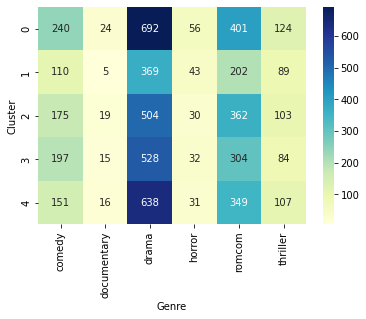

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap(clusters, ax=ax, cmap='YlGnBu', fmt='.0f', annot=True)

ax.set_xlabel('Genre')
ax.set_ylabel('Cluster')
plt.show()

The drama genre is present in highest number in each cluster. This could be because of the uneven distribution in the original dataframe. Apart from that, thriller genre is mostly present in cluster 0. Romcom is present in cluser 0 and 2. Drama genre is present in cluster 0 and 4. Comedy genre is present in cluster 0 and 3. Documentary and horror genre have very low appearances.

# Q.3 Comparing Classifiers

We are applying five different classifiers. As a baseline classifier, we will implement dummy classifier with two different strategies. We will not pre-process the data yet so as to make useful comparisons later. First, we will create a function to be called each time we want to retrieve evaluation metrics.

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def evaluate(val, val_predictions):
    val_precision, val_recall, val_f1, support = precision_recall_fscore_support(val['meta.genre'], val_predictions, average='macro')
    val_accuracy = (val['meta.genre'] == val_predictions).mean()
    print(f'Validation accuracy: {val_accuracy:.3f}')
    print(f'Validation precision (macro-averaged): {val_precision:.3f}')
    print(f'Validation recall (macro-averaged): {val_recall:.3f}')
    print(f'Validation F1-score (macro-averaged): {val_f1:.3f}')
    label_dist = pd.Series(val_predictions).value_counts()
    print(label_dist)
    
    plt.bar(label_dist.index, label_dist.values)
    plt.title("Label Distribution")
    plt.xlabel("Genre")
    plt.ylabel("Frequency")
    plt.show()


# Dummy Classifier (Strategy = most_frequent)

First, we will implement Dummy Classifier with the strategy = most_frequent, which will give the most frequent label.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation accuracy: 0.455
Validation precision (macro-averaged): 0.076
Validation recall (macro-averaged): 0.167
Validation F1-score (macro-averaged): 0.104
drama    2000
dtype: int64


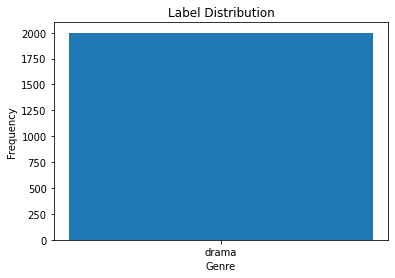

In [140]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train['text'], train['meta.genre'])
prediction = dummy_clf.predict(train[['text']])

val_predictions = dummy_clf.predict(val[['text']])
val_accuracy = accuracy_score(val['meta.genre'], val_predictions)
evaluate(val, val_predictions)

As the strategy includes labels most frequent, the graph only shows drama. Next, we use Stratified Split.

# Dummy Classifier (Strategy = stratified)

Validation accuracy: 0.320
Validation precision (macro-averaged): 0.169
Validation recall (macro-averaged): 0.170
Validation F1-score (macro-averaged): 0.169
drama          886
romcom         556
comedy         297
thriller       182
horror          55
documentary     24
dtype: int64


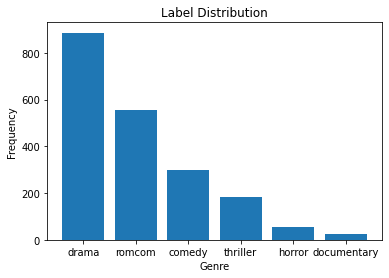

In [141]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(train['text'], train['meta.genre'])
prediction = dummy_clf.predict(train[['text']])

val_predictions = dummy_clf.predict(val[['text']])
val_accuracy = accuracy_score(val['meta.genre'], val_predictions)
evaluate(val, val_predictions)

We have already implemented stratified split on our data hence, the data shows a distribution like the initial distribution graph.

Before implementing the other classifiers, we will pre-process the data. This includes tokenisation, stemming lemmatization, and stop-word removal. Unlike as previously, we will not use custom functions. Instead, we will use various libraries.

# Pre-processing

We will copy the various sets so that the original dataframes remain unchanged.

In [142]:
classifiers_train = train.copy()
classifiers_test = test.copy()
classifiers_val = val.copy()

We implement two tokenising approaches; NLTK punkt and spaCy tokeniser. The latter produced better results.

In [143]:
#import spacy
#import nltk

#nltk.download('punkt')  # download NLTK's punkt tokenizer

# download and load spaCy's English language model
#spacy.cli.download('en_core_web_sm')
#nlp = spacy.load('en_core_web_sm')

#def tokenize_text(text):
    #return [token.text for token in nlp(text)]

In [144]:
import spacy
import pandas as pd

nlp = spacy.load('en_core_web_sm')

def tokenize_text(text):
    return [token.text for token in nlp(text)]

classifiers_train['tokens'] = classifiers_train['text'].apply(tokenize_text)
classifiers_test['tokens'] = classifiers_test['text'].apply(tokenize_text)
classifiers_val['tokens'] = val['text'].apply(tokenize_text)

Stemming is implemented using SnowballStemmer and NLTK PorterStemmer. Snowball Stemmer showed better results.

In [145]:
#import pandas as pd
#from nltk.stem import PorterStemmer

#stemmer = PorterStemmer()

#def stem_text(tokens):
    #stemmed_tokens = []
    #for token in tokens:
        #stemmed_tokens.append(stemmer.stem(token))
    #return stemmed_tokens

In [146]:
import pandas as pd
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_text(tokens):
    stemmed_tokens = []
    for token in tokens:
        stemmed_tokens.append(stemmer.stem(token))
    return stemmed_tokens

classifiers_train['tokens'] = classifiers_train['tokens'].apply(stem_text)
classifiers_test['tokens'] = classifiers_test['tokens'].apply(stem_text)
classifiers_val['tokens'] = classifiers_val['tokens'].apply(stem_text)

Lemmatization is also carried out using spaCy.

In [147]:
import spacy

nlp = spacy.load('en_core_web_sm')  

def lemmatize_text(text):
    lemmatized_tokens = []
    for token in text:
        lemmatized_tokens.append(nlp(token)[0].lemma_)
    return lemmatized_tokens

classifiers_train['tokens'] = classifiers_train['tokens'].apply(lemmatize_text)
classifiers_test['tokens'] = classifiers_test['tokens'].apply(lemmatize_text)
classifiers_val['tokens'] = classifiers_val['tokens'].apply(lemmatize_text)

Stopwords are removed using an NLTK provided list.

In [148]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def remove_stopwords(tokens):
  tok = []
  for token in tokens:
    if token not in stop_words:
      tok.append(token)
  return tok


classifiers_train['tokens'] = classifiers_train['tokens'].apply(remove_stopwords)
classifiers_test['tokens'] = classifiers_test['tokens'].apply(remove_stopwords)
classifiers_val['tokens'] = classifiers_val['tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [149]:
# Convert token lists to space-separated strings
classifiers_train['text'] = classifiers_train['tokens'].apply(lambda tokens: ' '.join(tokens))
classifiers_val['text'] = classifiers_val['tokens'].apply(lambda tokens: ' '.join(tokens))

# LogisticRegression with One-Hot Vectorization

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation accuracy: 0.818
Validation precision (macro-averaged): 0.780
Validation recall (macro-averaged): 0.527
Validation F1-score (macro-averaged): 0.585
drama       1262
romcom       457
comedy       180
thriller      88
horror        13
dtype: int64


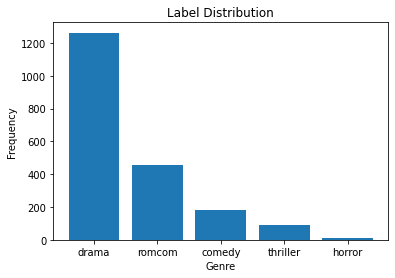

In [151]:
#logistic regression one hot encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(classifiers_train[['text']])
y_train = classifiers_train['meta.genre']
X_val = enc.transform(classifiers_val[['text']])
y_val = classifiers_val['meta.genre']


clf = LogisticRegression(random_state=0).fit(X_train, y_train)
val_predictions = clf.predict(X_val)
evaluate(classifiers_val, val_predictions)

Additionally, we will also implement the Count Vectorizer which is a modified version of One-Hot Encoding as it includes the frequency.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation accuracy: 0.782
Validation precision (macro-averaged): 0.851
Validation recall (macro-averaged): 0.575
Validation F1-score (macro-averaged): 0.644
drama          1134
romcom          503
comedy          223
thriller        112
horror           22
documentary       6
dtype: int64


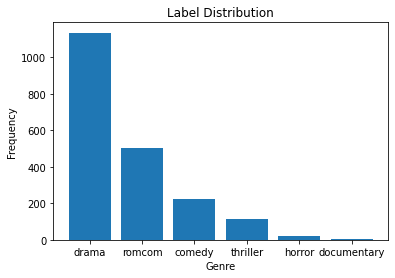

In [152]:
#Logistic Regression with Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(classifiers_train['text'])
y_train = classifiers_train['meta.genre']
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

X_val = vectorizer.transform(classifiers_val['text'])
y_val = classifiers_val['meta.genre']
val_predictions = clf.predict(X_val)

evaluate(classifiers_val, val_predictions)

# LogisticRegression with TF-IDF vectorization (default settings)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation accuracy: 0.726
Validation precision (macro-averaged): 0.706
Validation recall (macro-averaged): 0.453
Validation F1-score (macro-averaged): 0.498
drama       1245
romcom       490
comedy       175
thriller      82
horror         8
dtype: int64


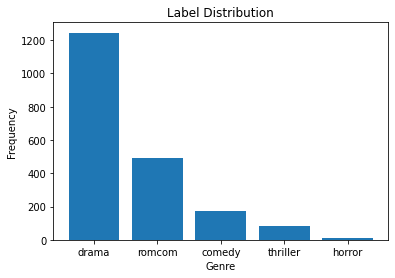

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(classifiers_train['text'])
y_train = classifiers_train['meta.genre']
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

X_val = vectorizer.transform(classifiers_val['text'])
y_val = classifiers_val['meta.genre']
val_predictions = clf.predict(X_val)

evaluate(classifiers_val, val_predictions)


# SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)

Validation accuracy: 0.870
Validation precision (macro-averaged): 0.958
Validation recall (macro-averaged): 0.647
Validation F1-score (macro-averaged): 0.720
drama          1155
romcom          457
comedy          237
thriller        125
horror           21
documentary       5
dtype: int64


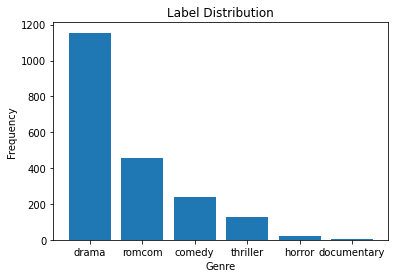

In [154]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC


enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(classifiers_train[['text']])
y_train = classifiers_train['meta.genre']
X_val = enc.transform(classifiers_val[['text']])
y_val = classifiers_val['meta.genre']

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

val_predictions = clf.predict(X_val)
evaluate(classifiers_val, val_predictions)


Since, we are getting the best F1-Score, we will also plot a bar chart graph with the F1 score for each class

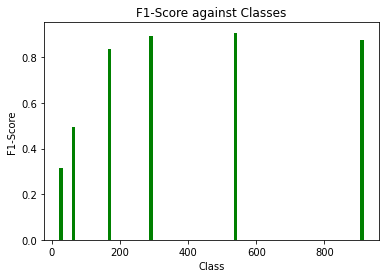

In [155]:
import matplotlib.pyplot as plt

_, _, f1_scores, classes = precision_recall_fscore_support(y_val, val_predictions, labels=clf.classes_)

fig, ax = plt.subplots()
ax.bar(classes, f1_scores, color='green', width = 10)
ax.set_xlabel('Class')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score against Classes')
plt.show()


Additionally, we will also implement the SVC Classifier with Count Vectorizer.

Validation accuracy: 0.773
Validation precision (macro-averaged): 0.912
Validation recall (macro-averaged): 0.541
Validation F1-score (macro-averaged): 0.617
drama          1252
romcom          433
comedy          198
thriller         97
horror           16
documentary       4
dtype: int64


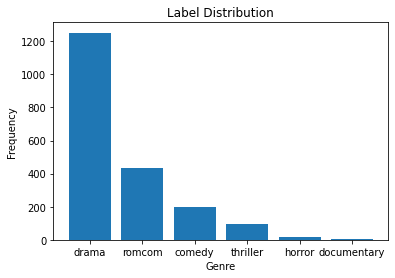

In [156]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(classifiers_train['text'])
y_train = classifiers_train['meta.genre']
clf = SVC(kernel='rbf',random_state=42, probability=True)
clf.fit(X_train, y_train)

X_val = vectorizer.transform(classifiers_val['text'])
y_val = classifiers_val['meta.genre']
val_predictions = clf.predict(X_val)
evaluate(classifiers_val, val_predictions)

# Own Approach - Random Forest

Now, we will implement a classifier of own choice which is Random Forest. The tokenisation approach remains the same as we selected the approaches that showed us best results. The vectorization approach chosen is One-Hot Vectorizer as it showed better results than other Vectorizing approaches like TF-IDF.

Validation accuracy: 0.882
Validation precision (macro-averaged): 0.961
Validation recall (macro-averaged): 0.739
Validation F1-score (macro-averaged): 0.818
drama          1130
romcom          455
comedy          240
thriller        125
horror           37
documentary      13
dtype: int64


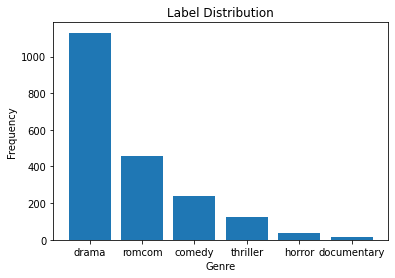

In [157]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(classifiers_train[['text']])
y_train = classifiers_train['meta.genre']
X_val = enc.transform(classifiers_val[['text']])
y_val = classifiers_val['meta.genre']


clf = RandomForestClassifier().fit(X_train, y_train)
val_predictions = clf.predict(X_val)
evaluate(classifiers_val, val_predictions)

# Q.4 Parameter Tuning

First we will implement parameter tuning based on the requirements asked in the assignment. These include; 

1. Classifier - Regularisation C value 
2. Vectorizer - Parameters: sublinear_tf and max_features 

We need to install Pipeline to carry out this task


In [159]:
pip install Pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will also build a function that calculates all evaluation metrics. First, we will only tune the C value parameter

In [162]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_hyperparameters(val, val_predictions, search):
    val_precision, val_recall, val_f1, support = precision_recall_fscore_support(val['meta.genre'], val_predictions, average='macro')
    val_accuracy = (val['meta.genre'] == val_predictions).mean()
    print(f'Validation accuracy after tuning feature: {val_accuracy:.3f}')
    print(f'Validation precision (macro-averaged) after tuning feature: {val_precision:.3f}')
    print(f'Validation recall (macro-averaged) after tuning feature: {val_recall:.3f}')
    print(f'Validation F1-score (macro-averaged) after tuning feature: {val_f1:.3f}')
    print(f'Best parameters after tuning feature: {search.best_params_}')

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_1 = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

clf = LogisticRegression(max_iter=10000)
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search = GridSearchCV(pipe, param_grid_1, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])
best_model = search.best_estimator_
val_predictions = best_model.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions, search)

Validation accuracy after tuning feature: 0.833
Validation precision (macro-averaged) after tuning feature: 0.809
Validation recall (macro-averaged) after tuning feature: 0.697
Validation F1-score (macro-averaged) after tuning feature: 0.741
Best parameters after tuning feature: {'clf__C': 1000}


This has shown an improvement. Next, we will tune Sublinear_tf and max_features parameters

In [180]:
#only tuning sublinear_tf

param_grid_2 = {
    'tfidf__sublinear_tf': [True, False]
}

clf = LogisticRegression(max_iter=10000)
pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search = GridSearchCV(pipe_2, param_grid_2, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])
best_model = search.best_estimator_
val_predictions = best_model.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions, search)

Validation accuracy after tuning feature: 0.724
Validation precision (macro-averaged) after tuning feature: 0.685
Validation recall (macro-averaged) after tuning feature: 0.448
Validation F1-score (macro-averaged) after tuning feature: 0.492
Best parameters after tuning feature: {'tfidf__sublinear_tf': True}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The performance has downgraded.

In [179]:
#only tuning max_features

param_grid_2 = {
    'tfidf__max_features': [None, 50000]
}

clf = LogisticRegression(max_iter=10000)
pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search = GridSearchCV(pipe_2, param_grid_2, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])
best_model = search.best_estimator_
val_predictions = best_model.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions, search)

Validation accuracy after tuning feature: 0.726
Validation precision (macro-averaged) after tuning feature: 0.706
Validation recall (macro-averaged) after tuning feature: 0.453
Validation F1-score (macro-averaged) after tuning feature: 0.498
Best parameters after tuning feature: {'tfidf__max_features': None}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tfidf__max_features also has shown no improvement. Hence, we will drop these. Now, we will tune additional parameters. These include clf__solver, clf__multi_class (for classifier tuning) and tfidf__ngram_range, tfidf__max_df, tfidf__min_df (for vectorizer tuning) 

In [166]:
param_grid_3 = {
    'clf__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

clf = LogisticRegression(max_iter=10000)
pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search_3 = GridSearchCV(pipe_3, param_grid_3, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])

best_model_3 = search_3.best_estimator_
val_predictions = best_model_3.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions, search_3)

Validation accuracy after tuning feature: 0.726
Validation precision (macro-averaged) after tuning feature: 0.706
Validation recall (macro-averaged) after tuning feature: 0.453
Validation F1-score (macro-averaged) after tuning feature: 0.498
Best parameters after tuning feature: {'clf__solver': 'saga'}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There is again no improvement.

In [167]:
param_grid_3 = {
    'clf__multi_class': ['ovr', 'multinomial']
}

clf = LogisticRegression(max_iter=10000)
pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search_3 = GridSearchCV(pipe_3, param_grid_3, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])
best_model_3 = search_3.best_estimator_
val_predictions_3 = best_model_3.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions_3, search_3)


Validation accuracy after tuning feature: 0.726
Validation precision (macro-averaged) after tuning feature: 0.706
Validation recall (macro-averaged) after tuning feature: 0.453
Validation F1-score (macro-averaged) after tuning feature: 0.498
Best parameters after tuning feature: {'clf__multi_class': 'multinomial'}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best parameter after tuning clf__multi_class is multinomial. There is no improvement. Next, we tune parameters for vectorizer.

In [168]:
param_grid_3 = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]
}


clf = LogisticRegression(max_iter=10000)
pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search_3 = GridSearchCV(pipe_3, param_grid_3, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])

best_model_3 = search_3.best_estimator_
val_predictions_3 = best_model_3.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions_3, search_3)



Validation accuracy after tuning feature: 0.783
Validation precision (macro-averaged) after tuning feature: 0.747
Validation recall (macro-averaged) after tuning feature: 0.506
Validation F1-score (macro-averaged) after tuning feature: 0.558
Best parameters after tuning feature: {'tfidf__ngram_range': (1, 2)}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There is a slight better performance.

In [169]:
param_grid_3 = {
    'tfidf__max_df': [0.5] #ignore terms that appear in more than 50% of the documents
}

clf = LogisticRegression(max_iter=10000)
pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search_3 = GridSearchCV(pipe_3, param_grid_3, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])

best_model_3 = search_3.best_estimator_
val_predictions_3 = best_model_3.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions_3, search_3)

Validation accuracy after tuning feature: 0.726
Validation precision (macro-averaged) after tuning feature: 0.706
Validation recall (macro-averaged) after tuning feature: 0.453
Validation F1-score (macro-averaged) after tuning feature: 0.498
Best parameters after tuning feature: {'tfidf__max_df': 0.5}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement is seen.

In [170]:
param_grid_3 = {
    'tfidf__min_df': [1, 5, 10]
}


clf = LogisticRegression(max_iter=10000)
pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', clf)
])

search_3 = GridSearchCV(pipe_3, param_grid_3, cv=5).fit(classifiers_train['text'], classifiers_train['meta.genre'])

best_model_3 = search_3.best_estimator_
val_predictions_3 = best_model_3.predict(classifiers_val['text'])
evaluate_hyperparameters(classifiers_val, val_predictions_3, search_3)

Validation accuracy after tuning feature: 0.726
Validation precision (macro-averaged) after tuning feature: 0.706
Validation recall (macro-averaged) after tuning feature: 0.453
Validation F1-score (macro-averaged) after tuning feature: 0.498
Best parameters after tuning feature: {'tfidf__min_df': 1}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Again, the metrics show no improvement.

Now, we will use all the best paramaters with Logistic Regression TF-IDF approach.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation accuracy: 0.859
Validation precision (macro-averaged): 0.846
Validation recall (macro-averaged): 0.727
Validation F1-score (macro-averaged): 0.773
drama          1018
romcom          507
comedy          268
thriller        145
horror           47
documentary      15
dtype: int64


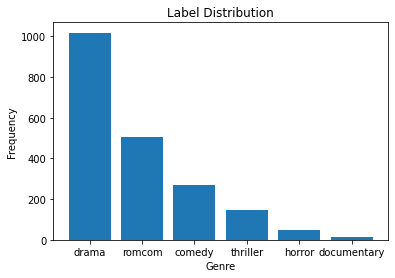

In [183]:
vectorizer = TfidfVectorizer(ngram_range = (1, 2))
clf = LogisticRegression(C=1000)
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('clf', clf)
])

pipe.fit(classifiers_train['text'], classifiers_train['meta.genre'])
val_predictions = pipe.predict(classifiers_val['text'])
evaluate(classifiers_val, val_predictions)

Overall, we can conclude that parameter tuning has resulted in a better performance.